# Data Dictionary

# [Link to dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

**Content**

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.
For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

**Labels**

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot


**TL;DR**

* Each row is a separate image
* Column 1 is the class label.
* Remaining columns are pixel numbers (784 total).
* Each value is the darkness of the pixel (1 to 255)

# Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, ReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    auc,
    roc_curve
)
from sklearn.decomposition import PCA

print(f"TensorFlow Version: {tf.__version__}")

2025-07-22 03:56:26.804547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753156587.098606      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753156587.188223      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0


In [3]:
train = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')
train

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          2       0       0       0       0       0       0       0       0   
1          9       0       0       0       0       0       0       0       0   
2          6       0       0       0       0       0       0       0       5   
3          0       0       0       0       1       2       0       0       0   
4          3       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
59995      9       0       0       0       0       0       0       0       0   
59996      1       0       0       0       0       0       0       0       0   
59997      8       0       0       0       0       0       0       0       0   
59998      8       0       0       0       0       0       0       0       0   
59999      7       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0        30        43   
3           0  ...         3         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
59995       0  ...         0         0         0         0         0   
59996       0  ...        73         0         0         0         0   
59997       0  ...       160       162       163       135        94   
59998       0  ...         0         0         0         0         0   
59999       0  ...         0         0         0         0         0   

       pixel780  pixel781  pixel782  pixel783  pixel784  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             1         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
59995         0         0         0         0         0  
59996         0         0         0         0         0  
59997         0         0         0         0         0  
59998         0         0         0         0         0  
59999         0         0         0         0         0  

[60000 rows x 785 columns]

# Data visualization

## Basic Statistics

In [4]:
train.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [6]:
train.describe()

label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.247967      0.411467      0.805767      2.198283      5.682000   
std        4.306912      5.836188      8.215169     14.093378     23.819481   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      227.000000    230.000000    224.000000    255.000000    254.000000   

       ...      pixel775      pixel776      pixel777      pixel778  \
count  ...  60000.000000  60000.000000  60000.000000  60000.000000   
mean   ...     34.625400     23.300683     16.588267     17.869433   
std    ...     57.545242     48.854427     41.979611     43.966032   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...     58.000000      9.000000      0.000000      0.000000   
max    ...    255.000000    255.000000    255.000000    255.000000   

           pixel779      pixel780      pixel781      pixel782      pixel783  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      22.814817     17.911483      8.520633      2.753300      0.855517   
std       51.830477     45.149388     29.614859     17.397652      9.356960   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

          pixel784  
count  60000.00000  
mean       0.07025  
std        2.12587  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        0.00000  
max      170.00000  

[8 rows x 785 columns]

## Plot distribution of pixel in train dataframe


--- Distribution of Pixel Intensities in Training Data ---
Shape of all_pixel_values: (47040000,)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


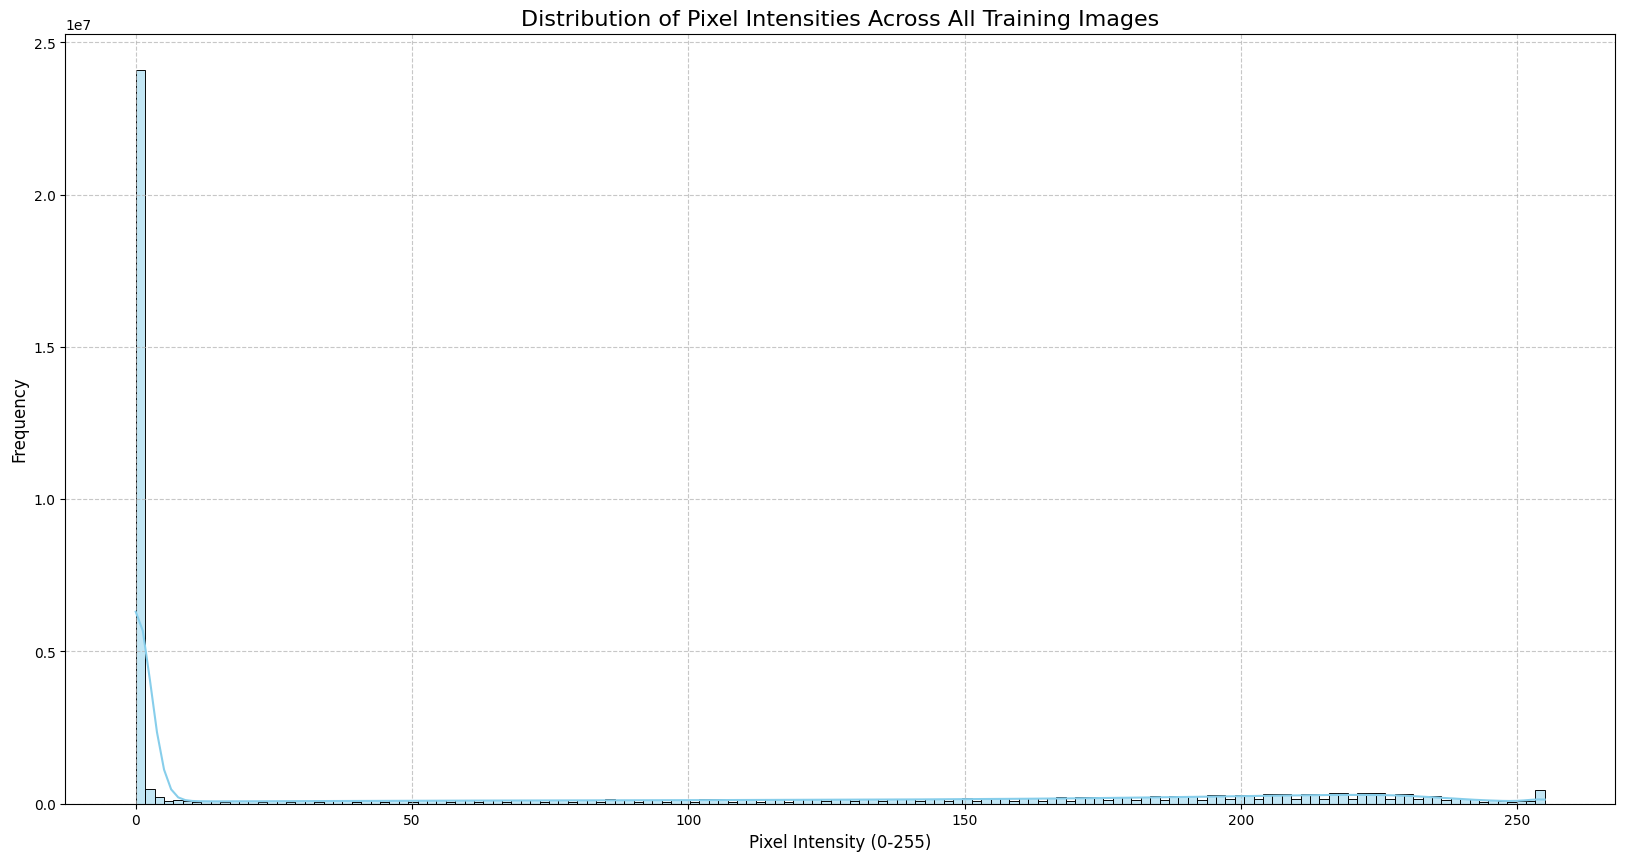

In [7]:
# --- Plot distribution of pixel in train dataframe ---
print("\n--- Distribution of Pixel Intensities in Training Data ---")

# Select only the pixel columns (excluding the 'label' column)
pixel_data = train.drop('label', axis=1)

# Flatten all pixel values into a single array
all_pixel_values = pixel_data.values.flatten()

# --- Fix for FutureWarning: Ensure no NaN or inf values are present ---
# This explicitly addresses the warning by cleaning the data before plotting.
# For pixel data (0-255), this is often redundant but good practice.
all_pixel_values = all_pixel_values[~np.isinf(all_pixel_values)]
all_pixel_values = all_pixel_values[~np.isnan(all_pixel_values)]
# --- End of Fix ---

print(f"Shape of all_pixel_values: {all_pixel_values.shape}")
if all_pixel_values.size > 0:
    plt.figure(figsize=(20, 10))
    sns.histplot(all_pixel_values, bins=150, kde=True, color='skyblue')
    plt.title('Distribution of Pixel Intensities Across All Training Images', fontsize=16)
    plt.xlabel('Pixel Intensity (0-255)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No pixel data available to plot the distribution.")

## Re-check labels in dataset

In [8]:
label = train['label']
label = set(label)
label

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [9]:
train['label'].value_counts(normalize=True)*100

label
2    10.0
9    10.0
6    10.0
0    10.0
3    10.0
4    10.0
5    10.0
8    10.0
7    10.0
1    10.0
Name: proportion, dtype: float64

## Visualize dataset

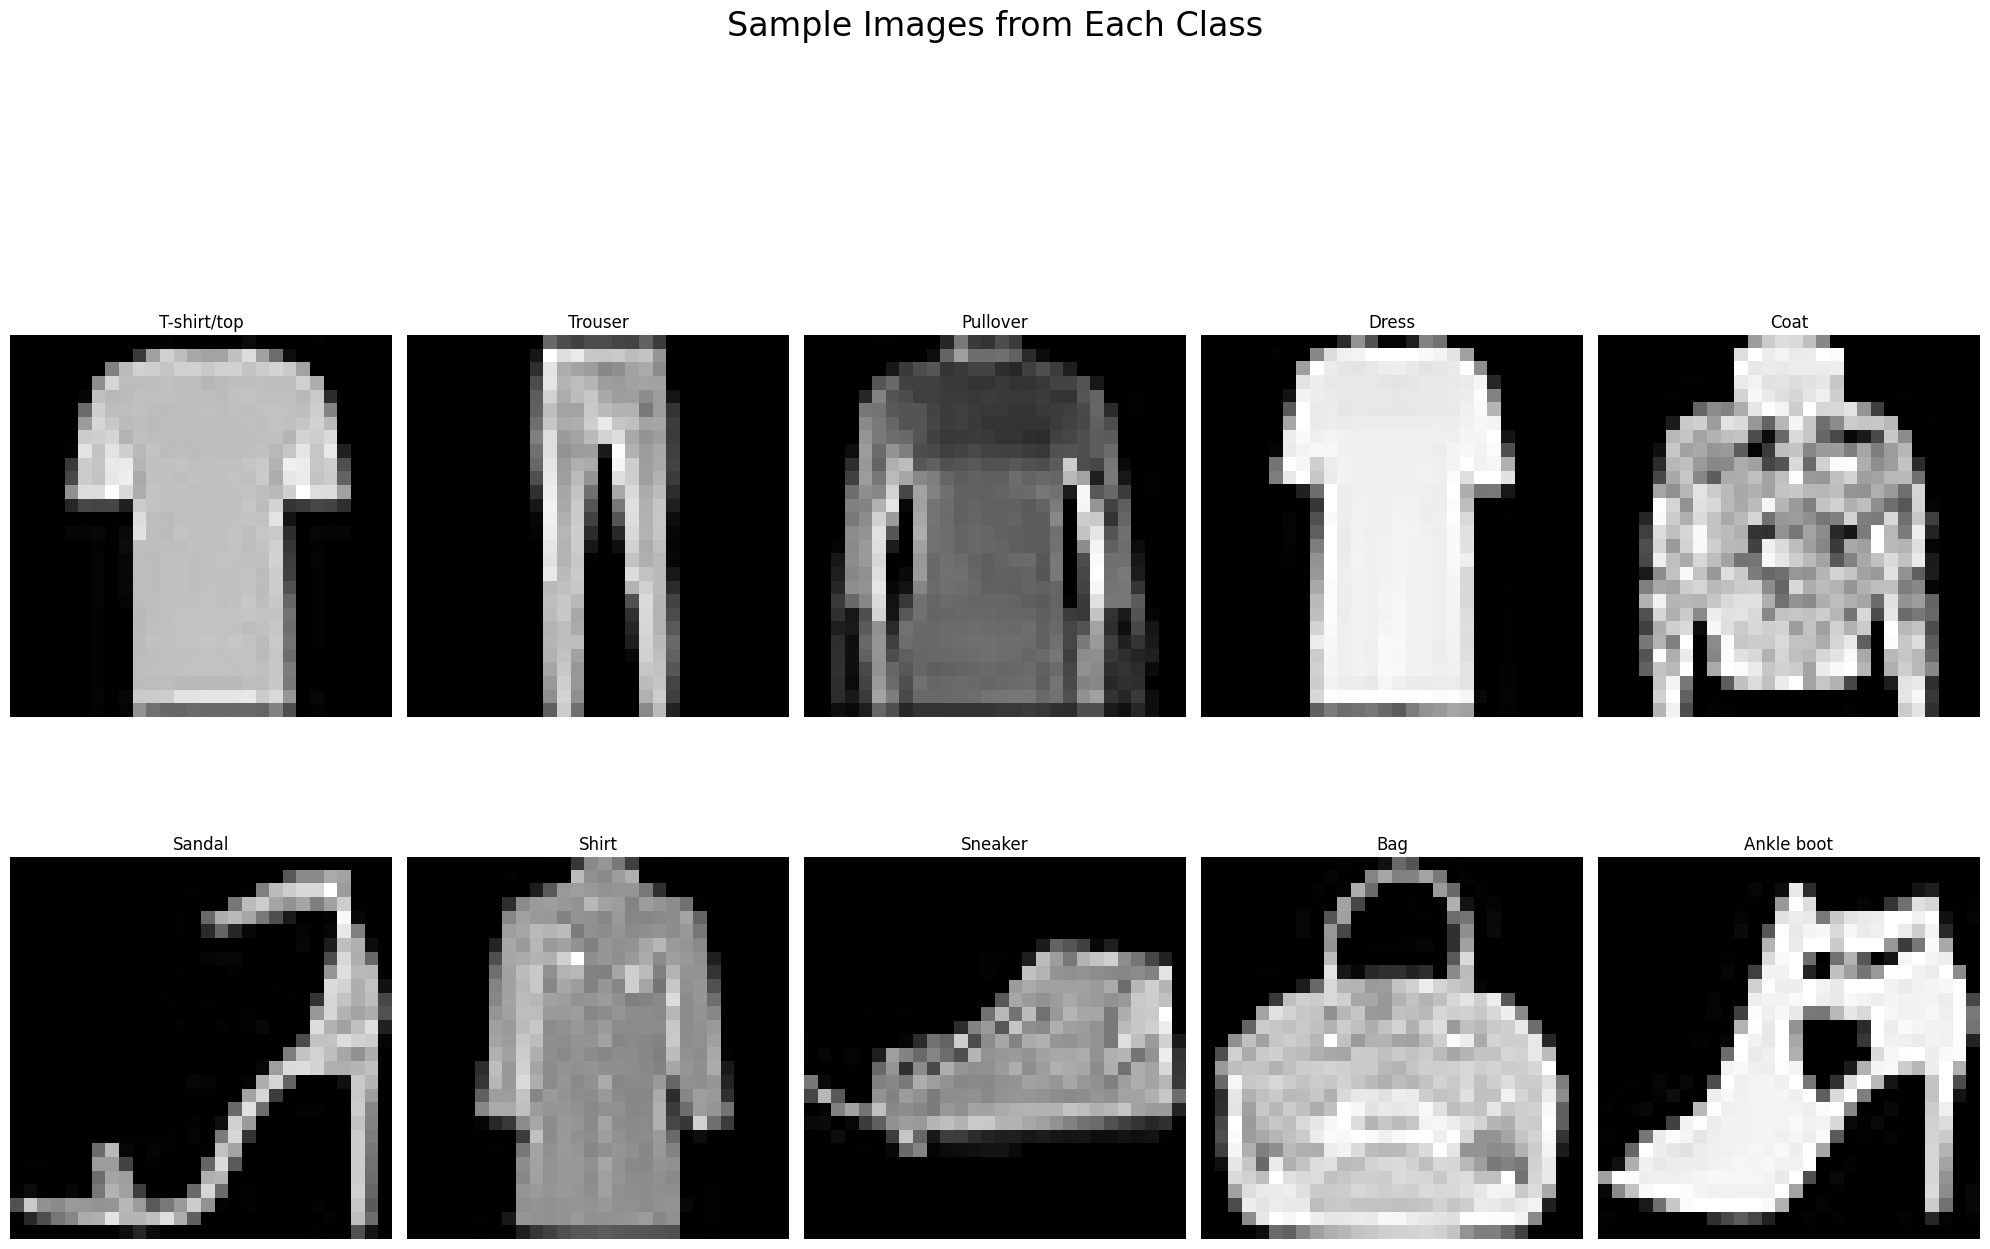

In [10]:
# --- Define 'y' as expected by your code ---
y = train['label']

# --- Dynamically get pixel column names ---
# Drop the 'label' column to get the pixel columns
pixel_cols = train.drop('label', axis=1).columns.tolist()


# --- Define the label dictionary (as provided in your query) ---
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

plt.figure(figsize=(20, 15)) # Adjusted figure size for better display
# Loop through each unique label to plot a sample image
for i, class_id in enumerate(label_dict.keys()): # Iterate through the keys (0-9) of the label_dict
    plt.subplot(2, 5, i + 1) # Create a 2x5 grid of subplots

    # Select samples belonging to the current class_id
    # Ensure y is a pandas Series for boolean indexing with .loc
    if isinstance(y, pd.Series):
        samples_for_class = train.loc[y == class_id, pixel_cols]
    else: # Fallback if y is a numpy array, convert to Series for .loc
        samples_for_class = train.loc[pd.Series(y) == class_id, pixel_cols]

    # Check if there are any samples for this class before trying to sample
    if not samples_for_class.empty:
        # Take one random sample from the selected class
        sample = samples_for_class.sample(1)
        # Reshape the 1x784 (or 1x(28*28)) row into a 28x28 image array
        # .values[0] converts the DataFrame row to a NumPy array
        image_array = np.reshape(sample.values[0], (28, 28))

        # Display the image
        plt.gca().imshow(image_array, cmap='gray', vmin=0, vmax=255)
        # Set the title using the descriptive label from the dictionary
        plt.title(label_dict[class_id])
        plt.axis('off') # Turn off axis ticks and labels for cleaner image display
    else:
        plt.title(f"No samples for {label_dict[class_id]}")
        plt.axis('off')


plt.suptitle('Sample Images from Each Class\n', fontsize=24) # Add a main title
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# Feature Engineering

## Split features and target label

In [11]:
x_train_raw = train.drop('label', axis=1)
y_train_raw = train['label']
x_test_raw = test.drop('label', axis=1)
y_test_raw = test['label']

# Print the shapes of the resulting sets
print("X_train shape:", x_train_raw.shape)
print("y_train shape:", x_test_raw.shape)
print("X_test shape:", x_test_raw.shape)
print("y_test shape:", y_test_raw.shape)

X_train shape: (60000, 784)
y_train shape: (10000, 784)
X_test shape: (10000, 784)
y_test shape: (10000,)


## Data Normalization

In [12]:
# Normalize pixel values to [0, 1]
x_train_normalized = x_train_raw.values / 255.0
x_test_normalized = x_test_raw.values / 255.0

# Reshape images for Keras CNN input: (batch_size, height, width, channels)
# Fashion MNIST images are grayscale, so channels = 1
x_train_cnn = x_train_normalized.reshape(-1, 28, 28, 1)
x_test_cnn = x_test_normalized.reshape(-1, 28, 28, 1)

# Keras typically uses integer labels for sparse_categorical_crossentropy
y_train_keras = y_train_raw.values
y_test_keras = y_test_raw.values

print(f"x_train_cnn shape: {x_train_cnn.shape}")
print(f"y_train_keras shape: {y_train_keras.shape}")
print(f"x_test_cnn shape: {x_test_cnn.shape}")
print(f"y_test_keras shape: {y_test_keras.shape}")
print("="*40 + "\n")

x_train_cnn shape: (60000, 28, 28, 1)
y_train_keras shape: (60000,)
x_test_cnn shape: (10000, 28, 28, 1)
y_test_keras shape: (10000,)



# Modeling

## Model Architecture, model building (Keras), and model training

In [13]:
# --- Define the CNN Model using Keras Sequential API ---
# Determine the number of classes from the training labels
num_classes = len(np.unique(y_train_keras))

# Define the model with an Input layer
model = Sequential([
    Input(shape=(28, 28, 1)),  # Explicit Input layer defining the shape
    # First convolutional block
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # Second convolutional block
    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    # Flatten the output for the dense layers
    Flatten(),
    
    # Fully connected layers
    Dense(128, activation='relu'),
    # Intermediate dense layer
    Dense(64, activation='relu', name='fc_intermediate'),  # Named for easier feature extraction
    # Output layer with softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# No need for model.build() since Input layer defines the shape

# Print the model summary
print("\n--- Keras CNN Model Architecture ---")
model.summary()
print("="*40 + "\n")

# --- Compile the Model ---
# Use Adam optimizer and sparse_categorical_crossentropy for integer labels
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- Define Early Stopping Callback ---
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=8,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# --- Training the Model ---
num_epochs = 100  # Max epochs, early stopping will stop it sooner
batch_size = 64
validation_split = 0.2

print("--- Starting Training ---")
history = model.fit(
    x_train_cnn, y_train_keras,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=validation_split,  # Keras handles validation split internally
    callbacks=[early_stopping],  # Apply early stopping
    verbose=1  # Show training progress
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras CNN Model Architecture ---


2025-07-22 04:00:31.879161: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_intermediate (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,258 (1.64 MB)

 Trainable params: 429,258 (1.64 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Training ---
Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 42ms/step - accuracy: 0.7442 - loss: 0.6950 - val_accuracy: 0.8779 - val_loss: 0.3405
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.8828 - loss: 0.3206 - val_accuracy: 0.8994 - val_loss: 0.2880
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.9025 - loss: 0.2678 - val_accuracy: 0.8876 - val_loss: 0.2976
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.9140 - loss: 0.2318 - val_accuracy: 0.8995 - val_loss: 0.2898
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.9209 - loss: 0.2104 - val_accuracy: 0.9162 - val_loss: 0.2457
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9291 - loss: 0.1885 - val_accuracy: 0.9149 - val_loss: 0.2396
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9389 - loss: 0.1672 - val_accuracy: 0.9188 - val_loss: 0.2397
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step -

## Visualize Model Training (Training loss and Model accuracy during training)

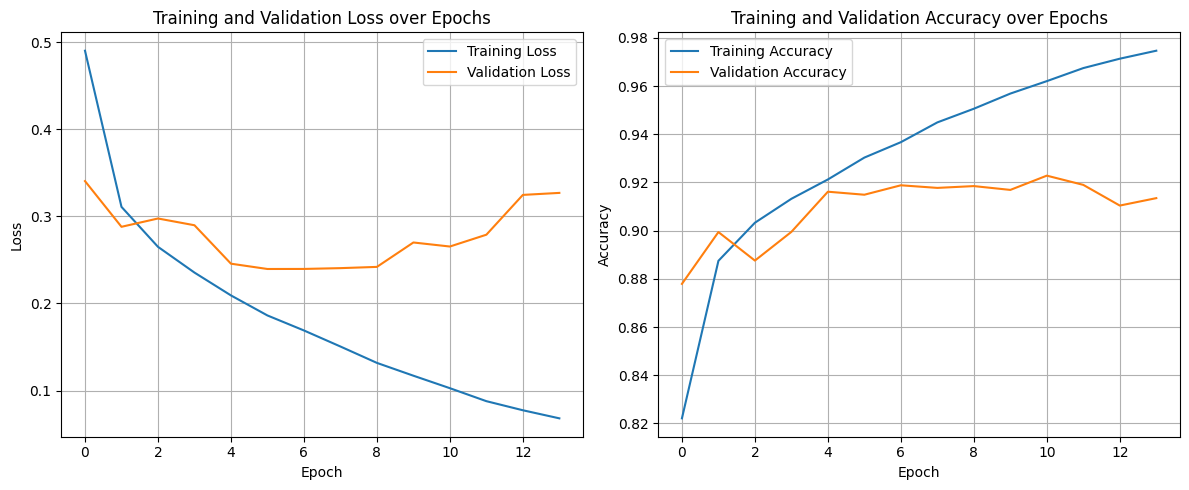

In [14]:
# --- Plotting Training History ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss') # Use history.history
plt.plot(history.history['val_loss'], label='Validation Loss') # Use history.history
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy') # Use history.history
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Use history.history
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Visualize Convolutional Layer Filters


--- Visualizing Convolutional Layer Filters ---


/tmp/ipykernel_13/1820891241.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


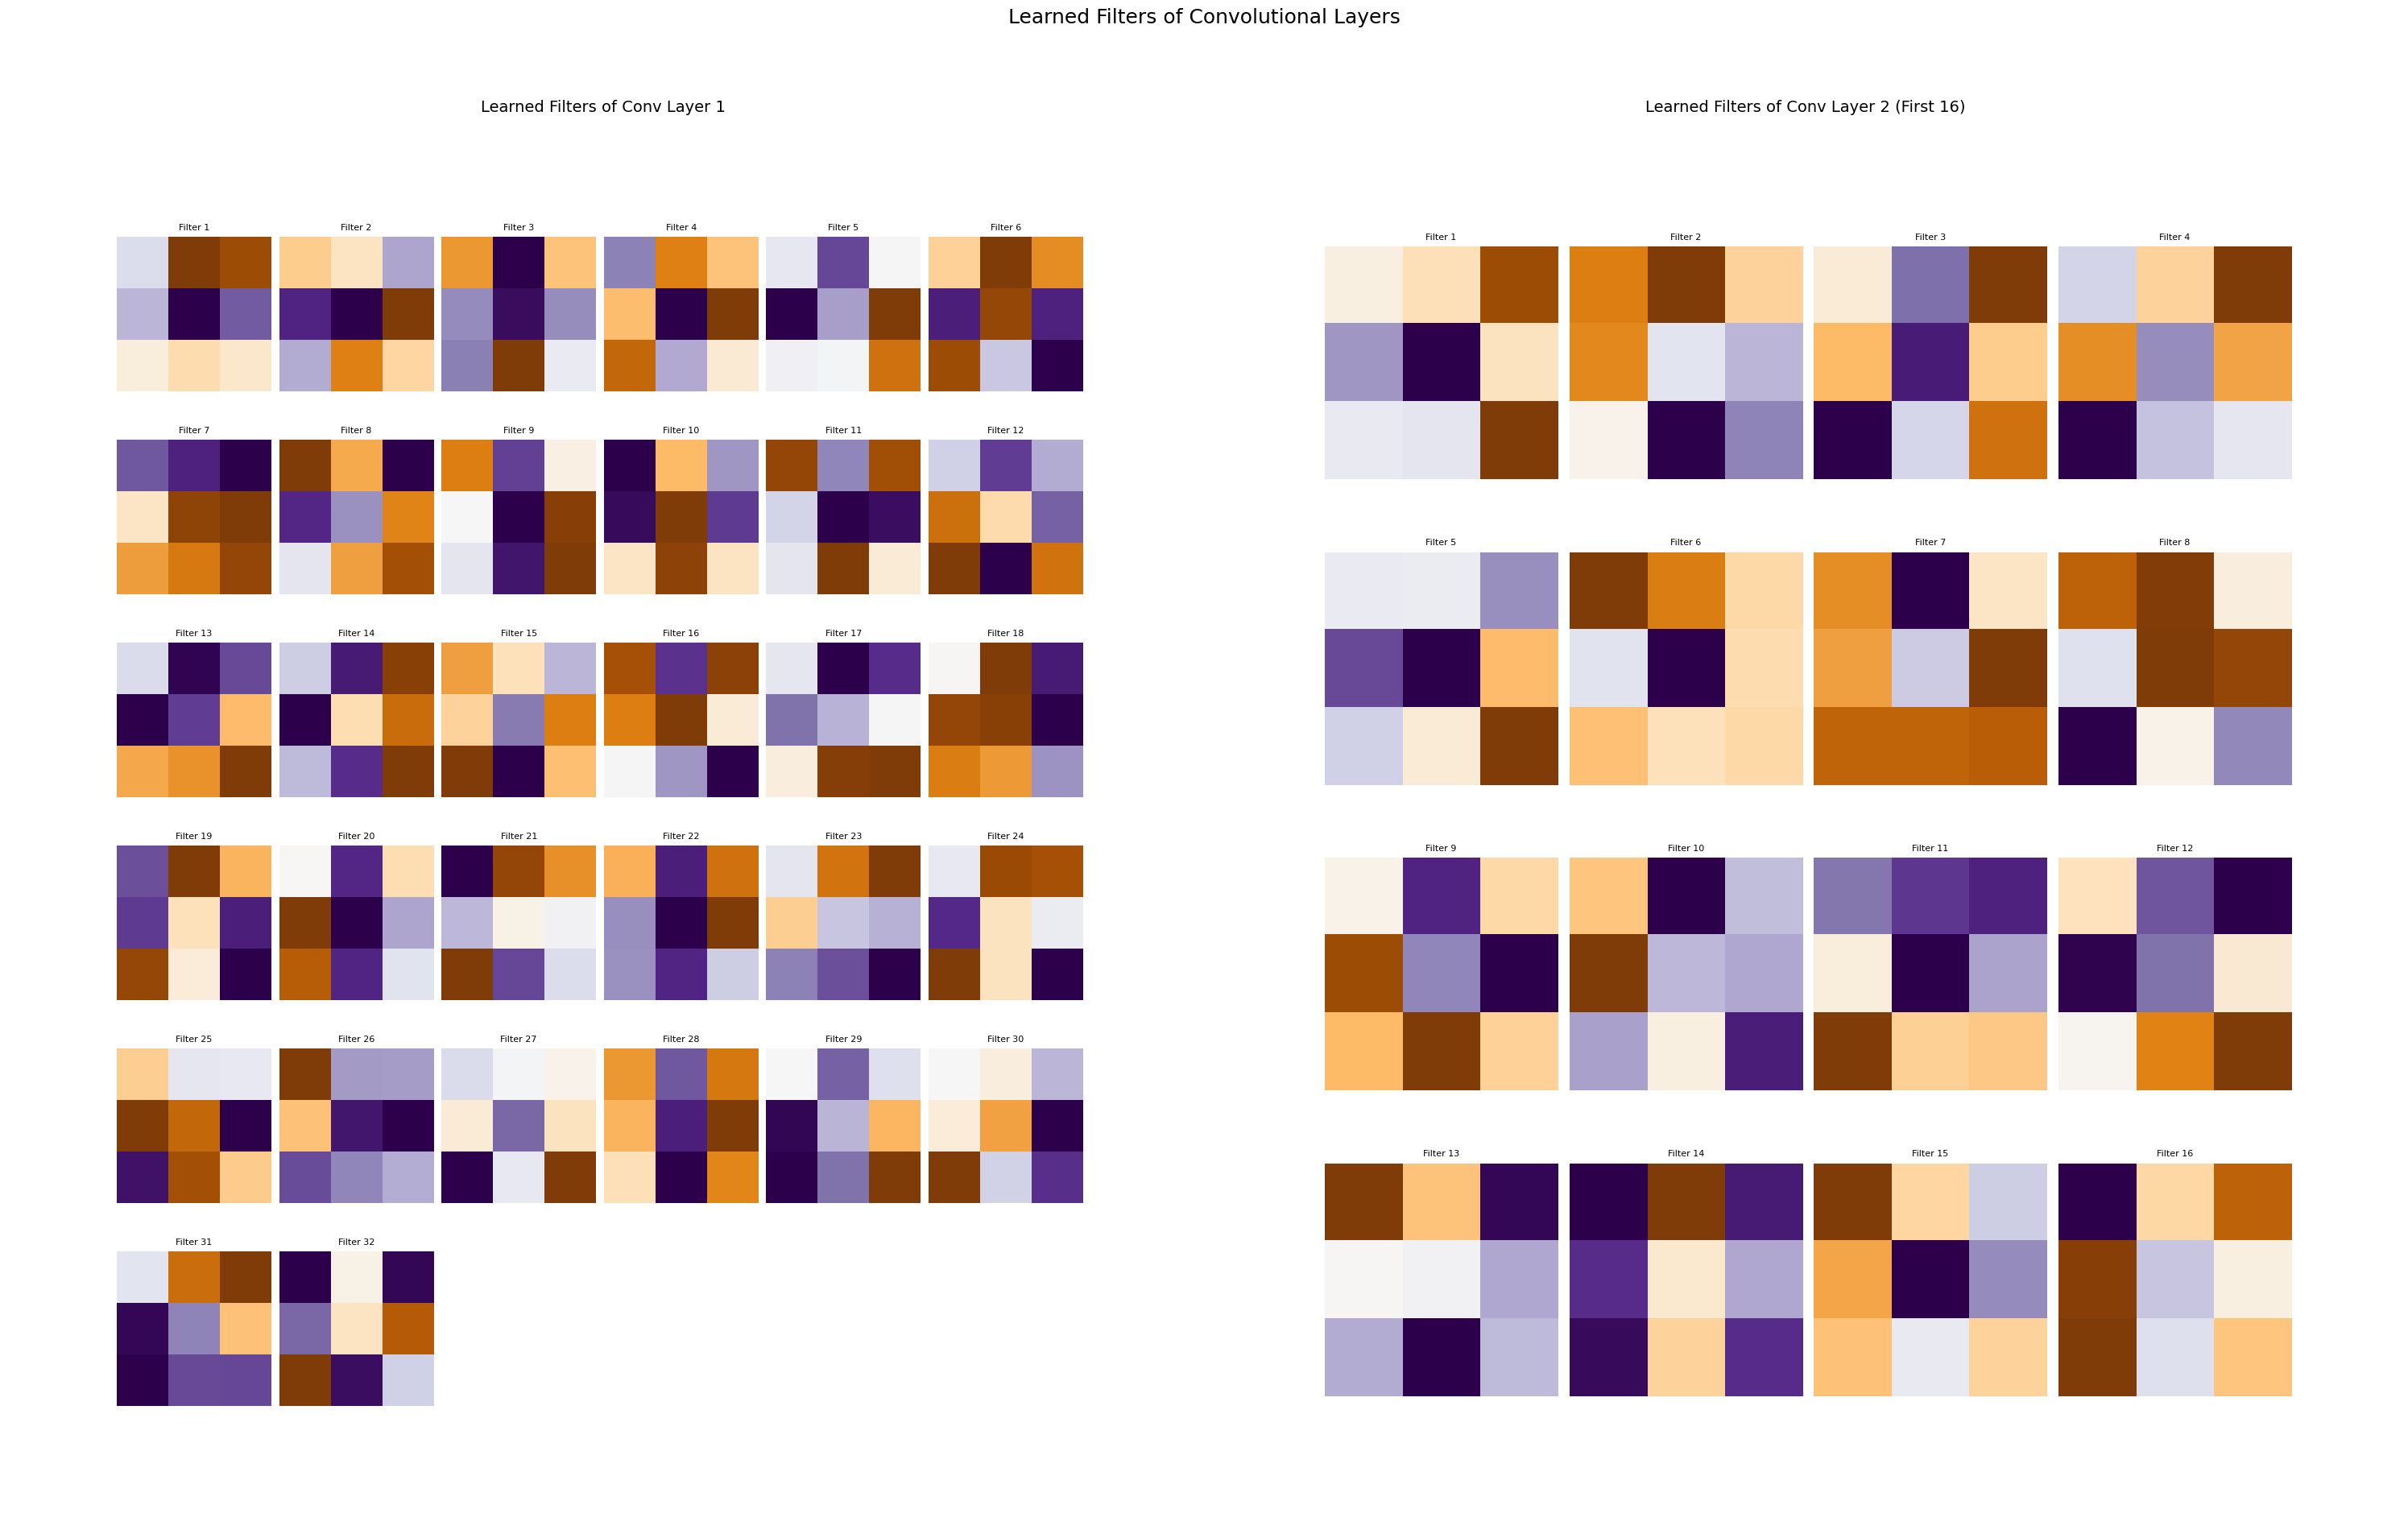

In [15]:
# --- Visualize Convolutional Layer Filters ---
print("\n--- Visualizing Convolutional Layer Filters ---")

# Access the weights of the first convolutional layer (conv1)
# Keras stores weights as a list: [kernel_weights, bias_weights]
# need the kernel_weights (the actual filters)
filters_conv1 = model.layers[0].get_weights()[0]
num_filters_conv1 = filters_conv1.shape[-1] # Number of output channels/filters

# Access the weights of the second convolutional layer (conv2)
filters_conv2 = model.layers[2].get_weights()[0] # Assuming Conv2D is at index 2
num_filters_conv2 = filters_conv2.shape[-1]

# Set a fixed figure size for both plots to be the same
fixed_figsize = (30, 20)

# Create the main figure and subplots for the filter visualization
fig, axes = plt.subplots(1, 2, figsize=fixed_figsize)

# Subplot 1: Convolutional Layer 1 Filters
ax1 = axes[0]
ax1.set_title('Learned Filters of Conv Layer 1', fontsize=14, pad=20)
ax1.axis('off')

grid_cols_conv1 = int(np.ceil(np.sqrt(num_filters_conv1)))
grid_rows_conv1 = int(np.ceil(num_filters_conv1 / grid_cols_conv1))

gs1 = plt.GridSpec(grid_rows_conv1, grid_cols_conv1, figure=fig)
gs1.update(left=0.05, right=0.45, wspace=0.05, hspace=0.05, top=0.85, bottom=0.1)

for i in range(num_filters_conv1):
    ax_filter1 = fig.add_subplot(gs1[i // grid_cols_conv1, i % grid_cols_conv1])
    # For grayscale input, filter_img is (kernel_height, kernel_width, 1, num_filters)
    # take the first (and only) input channel and squeeze
    filter_img = filters_conv1[:, :, 0, i]

    min_val, max_val = filter_img.min(), filter_img.max()
    if max_val - min_val > 1e-6:
        filter_img = (filter_img - min_val) / (max_val - min_val)
    else:
        filter_img = np.zeros_like(filter_img)

    ax_filter1.imshow(filter_img, cmap='PuOr')
    ax_filter1.set_title(f'Filter {i+1}', fontsize=8)
    ax_filter1.axis('off')

# Subplot 2: Convolutional Layer 2 Filters (First 16 for brevity)
ax2 = axes[1]
ax2.set_title('Learned Filters of Conv Layer 2 (First 16)', fontsize=14, pad=20)
ax2.axis('off')

plot_filters_count_conv2 = min(16, num_filters_conv2)
grid_cols_conv2 = int(np.ceil(np.sqrt(plot_filters_count_conv2)))
grid_rows_conv2 = int(np.ceil(plot_filters_count_conv2 / grid_cols_conv2))

gs2 = plt.GridSpec(grid_rows_conv2, grid_cols_conv2, figure=fig)
gs2.update(left=0.55, right=0.95, wspace=0.05, hspace=0.05, top=0.85, bottom=0.1)

for i in range(plot_filters_count_conv2):
    ax_filter2 = fig.add_subplot(gs2[i // grid_cols_conv2, i % grid_cols_conv2])
    # For Conv2, filters are (kernel_height, kernel_width, in_channels, out_channels)
    # take the mean across input channels to visualize
    filter_img_conv2 = filters_conv2[:, :, :, i].mean(axis=-1) # Mean across input channels

    min_val, max_val = filter_img_conv2.min(), filter_img_conv2.max()
    if max_val - min_val > 1e-6:
        filter_img_conv2 = (filter_img_conv2 - min_val) / (max_val - min_val)
    else:
        filter_img_conv2 = np.zeros_like(filter_img_conv2)

    ax_filter2.imshow(filter_img_conv2, cmap='PuOr')
    ax_filter2.set_title(f'Filter {i+1}', fontsize=8)
    ax_filter2.axis('off')

fig.suptitle('Learned Filters of Convolutional Layers', fontsize=18, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Visualizing Decision Boundary of the model


--- Visualizing CNN Decision Boundary using PCA ---
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/tmp/ipykernel_13/1463580694.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


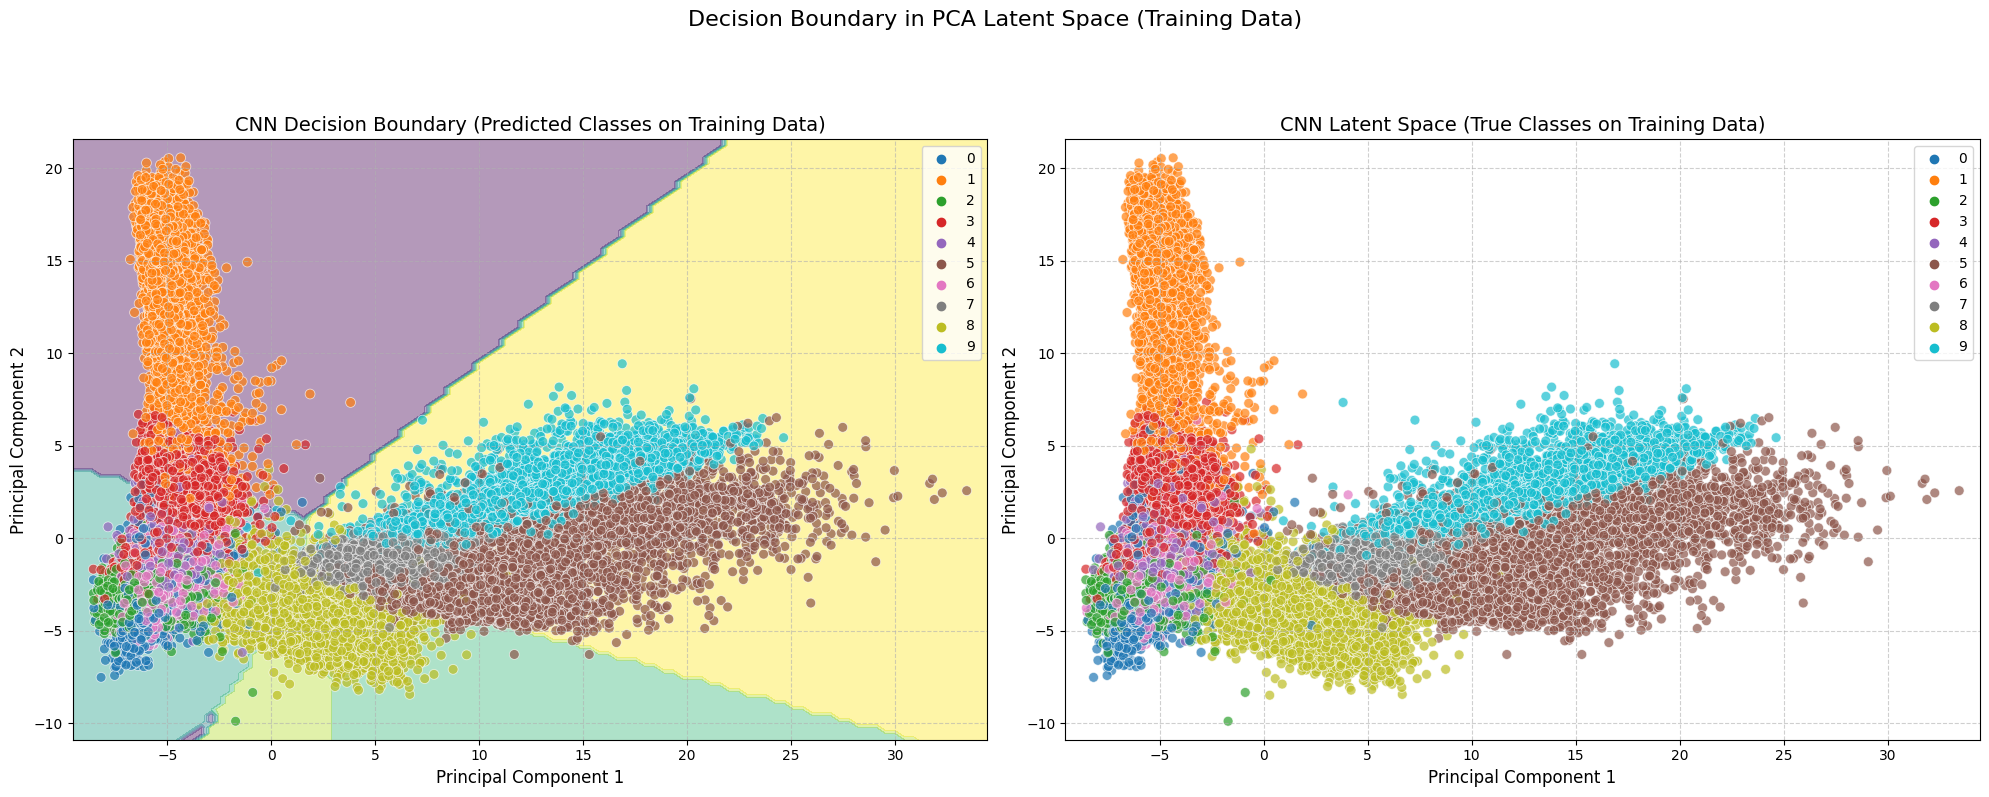

In [16]:
# --- Visualizing Decision Boundary in PCA-Reduced Latent Space ---
print("\n--- Visualizing CNN Decision Boundary using PCA ---")

# Function to create a sub-model up to the specified layer
def get_intermediate_model(model, layer_name):
    """Create a Sequential model with layers up to the specified layer name."""
    layer_index = [layer.name for layer in model.layers].index(layer_name)
    intermediate_model = Sequential(model.layers[:layer_index + 1])
    return intermediate_model

# Extract features from the 'fc_intermediate' layer using the trained model
intermediate_model = get_intermediate_model(model, 'fc_intermediate')
intermediate_features = intermediate_model.predict(x_train_cnn, batch_size=64)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(intermediate_features)

# Get model predictions for training data labels
predicted_labels = np.argmax(model.predict(x_train_cnn, batch_size=64), axis=1)

# Create meshgrid for decision boundary
x_min, x_max = pca_features[:, 0].min() - 1, pca_features[:, 0].max() + 1
y_min, y_max = pca_features[:, 1].min() - 1, pca_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]

# Reconstruct features from PCA space to original feature space
reconstructed_features = pca.inverse_transform(meshgrid_points)

# Create sub-model from 'fc_intermediate' to output
layer_index = [layer.name for layer in model.layers].index('fc_intermediate')
sub_model = Sequential(model.layers[layer_index + 1:])  # Layers after 'fc_intermediate'

# Predict on reconstructed features
Z_proba = sub_model.predict(reconstructed_features, batch_size=64)
Z = np.argmax(Z_proba, axis=1).reshape(xx.shape)

# Plotting with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
cmap = plt.cm.get_cmap('viridis', num_classes)

# Left subplot: Decision Boundary with Predicted Classes
contourf_plot = ax1.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=predicted_labels,
    palette=sns.color_palette("tab10", n_colors=num_classes),
    legend='full',
    alpha=0.7,
    s=50,
    ax=ax1
)
ax1.set_title('CNN Decision Boundary (Predicted Classes on Training Data)', fontsize=14)
ax1.set_xlabel('Principal Component 1', fontsize=12)
ax1.set_ylabel('Principal Component 2', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlim(xx.min(), xx.max())
ax1.set_ylim(yy.min(), yy.max())

# Right subplot: Latent Space with True Classes
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=y_train_keras,
    palette=sns.color_palette("tab10", n_colors=num_classes),
    legend='full',
    alpha=0.7,
    s=50,
    ax=ax2
)
ax2.set_title('CNN Latent Space (True Classes on Training Data)', fontsize=14)
ax2.set_xlabel('Principal Component 1', fontsize=12)
ax2.set_ylabel('Principal Component 2', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(yy.min(), yy.max())

# Overall title
fig.suptitle('Decision Boundary in PCA Latent Space (Training Data)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model Architecture, model building (TF custom layer), and model training

In [17]:
# --- Custom Activation Function ---
# A simple custom activation function: Leaky ReLU
@tf.function  # Decorator to compile the function into a TensorFlow graph for performance
def custom_leaky_relu(x, alpha=0.2):
    return tf.maximum(x, alpha * x)

# --- Custom Layer Definition ---
class CustomDenseLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, name=None, **kwargs):
        super(CustomDenseLayer, self).__init__(name=name, **kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)  # Get activation function by name

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.w = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True,
        )
        self.b = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
        )
        super(CustomDenseLayer, self).build(input_shape)  # Must call super.build()

    def call(self, inputs):
        # Perform the linear transformation: inputs @ self.w + self.b
        output = tf.matmul(inputs, self.w) + self.b
        # Apply the activation function if provided
        if self.activation is not None:
            output = self.activation(output)
        return output

    def get_config(self):
        config = super(CustomDenseLayer, self).get_config()
        config.update({
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation),
        })
        return config

# --- Define the CNN Model using Keras Sequential API with Custom Layer ---
# Determine the number of classes from the training labels
num_classes = len(np.unique(y_train_keras))

model = Sequential([
    Input(shape=(28, 28, 1)),  # Explicit Input layer defining the shape
    # First convolutional block
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    # Second convolutional block
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    # Flatten the output for the dense layers
    Flatten(),
    # Fully connected layers
    tf.keras.layers.Dense(128, activation='relu'),
    # Intermediate dense layer using the custom layer and custom function
    CustomDenseLayer(64, activation=custom_leaky_relu, name='fc_intermediate_custom'),  # Using custom layer and function
    # Output layer with softmax activation for multi-class classification
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Print the model summary
print("\n--- Keras CNN Model Architecture ---")
model.summary()
print("="*40 + "\n")

# --- Compile the Model ---
# Use Adam optimizer and sparse_categorical_crossentropy for integer labels
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- Define Early Stopping Callback ---
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=8,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# --- Training the Model ---
num_epochs = 100  # Max epochs, early stopping will stop it sooner
batch_size = 64
validation_split = 0.2

print("--- Starting Training ---")
history = model.fit(
    x_train_cnn, y_train_keras,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=validation_split,  # Keras handles validation split internally
    callbacks=[early_stopping],  # Apply early stopping
    verbose=1  # Show training progress
)
print("\n--- Training Complete ---")
print("="*40 + "\n")


--- Keras CNN Model Architecture ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_intermediate_custom          │ (None, 64)             │         8,256 │
│ (CustomDenseLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,258 (1.64 MB)

 Trainable params: 429,258 (1.64 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Training ---
Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.7681 - loss: 0.6584 - val_accuracy: 0.8782 - val_loss: 0.3357
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.8852 - loss: 0.3179 - val_accuracy: 0.8988 - val_loss: 0.2905
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 32s 42ms/step - accuracy: 0.9083 - loss: 0.2508 - val_accuracy: 0.9023 - val_loss: 0.2730
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9184 - loss: 0.2184 - val_accuracy: 0.9120 - val_loss: 0.2506
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step - accuracy: 0.9266 - loss: 0.1987 - val_accuracy: 0.9145 - val_loss: 0.2396
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.9390 - loss: 0.1674 - val_accuracy: 0.9146 - val_loss: 0.2352
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9471 - loss: 0.1446 - val_accuracy: 0.9147 - val_loss: 0.2391
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step -

## Visualize Model Training (Training loss and Model accuracy during training)

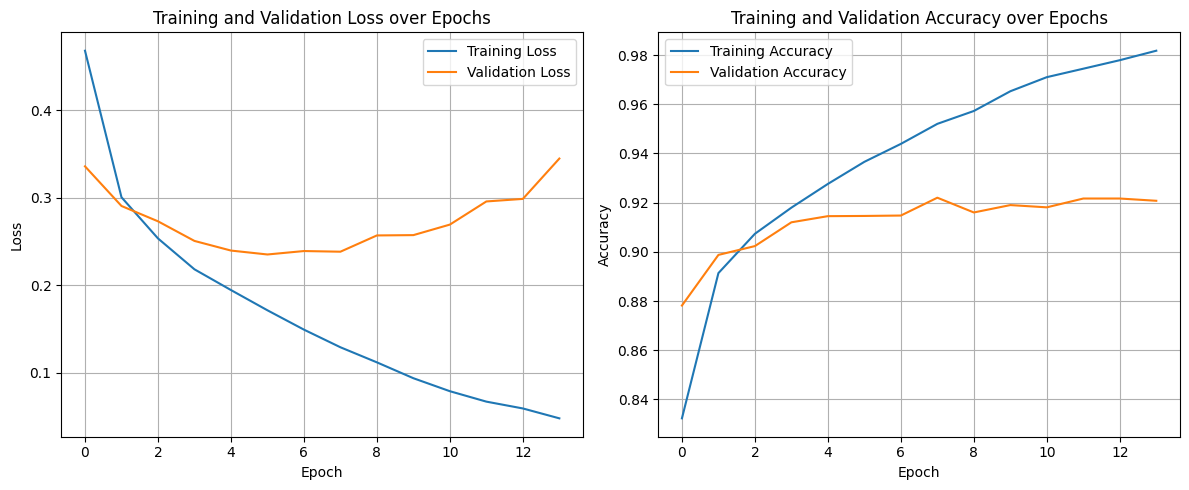

In [18]:
# --- Plotting Training History ---
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss') # Use history.history
plt.plot(history.history['val_loss'], label='Validation Loss') # Use history.history
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy') # Use history.history
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Use history.history
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Visualize Convolutional Layer Filters


--- Visualizing Convolutional Layer Filters ---


/tmp/ipykernel_13/1820891241.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


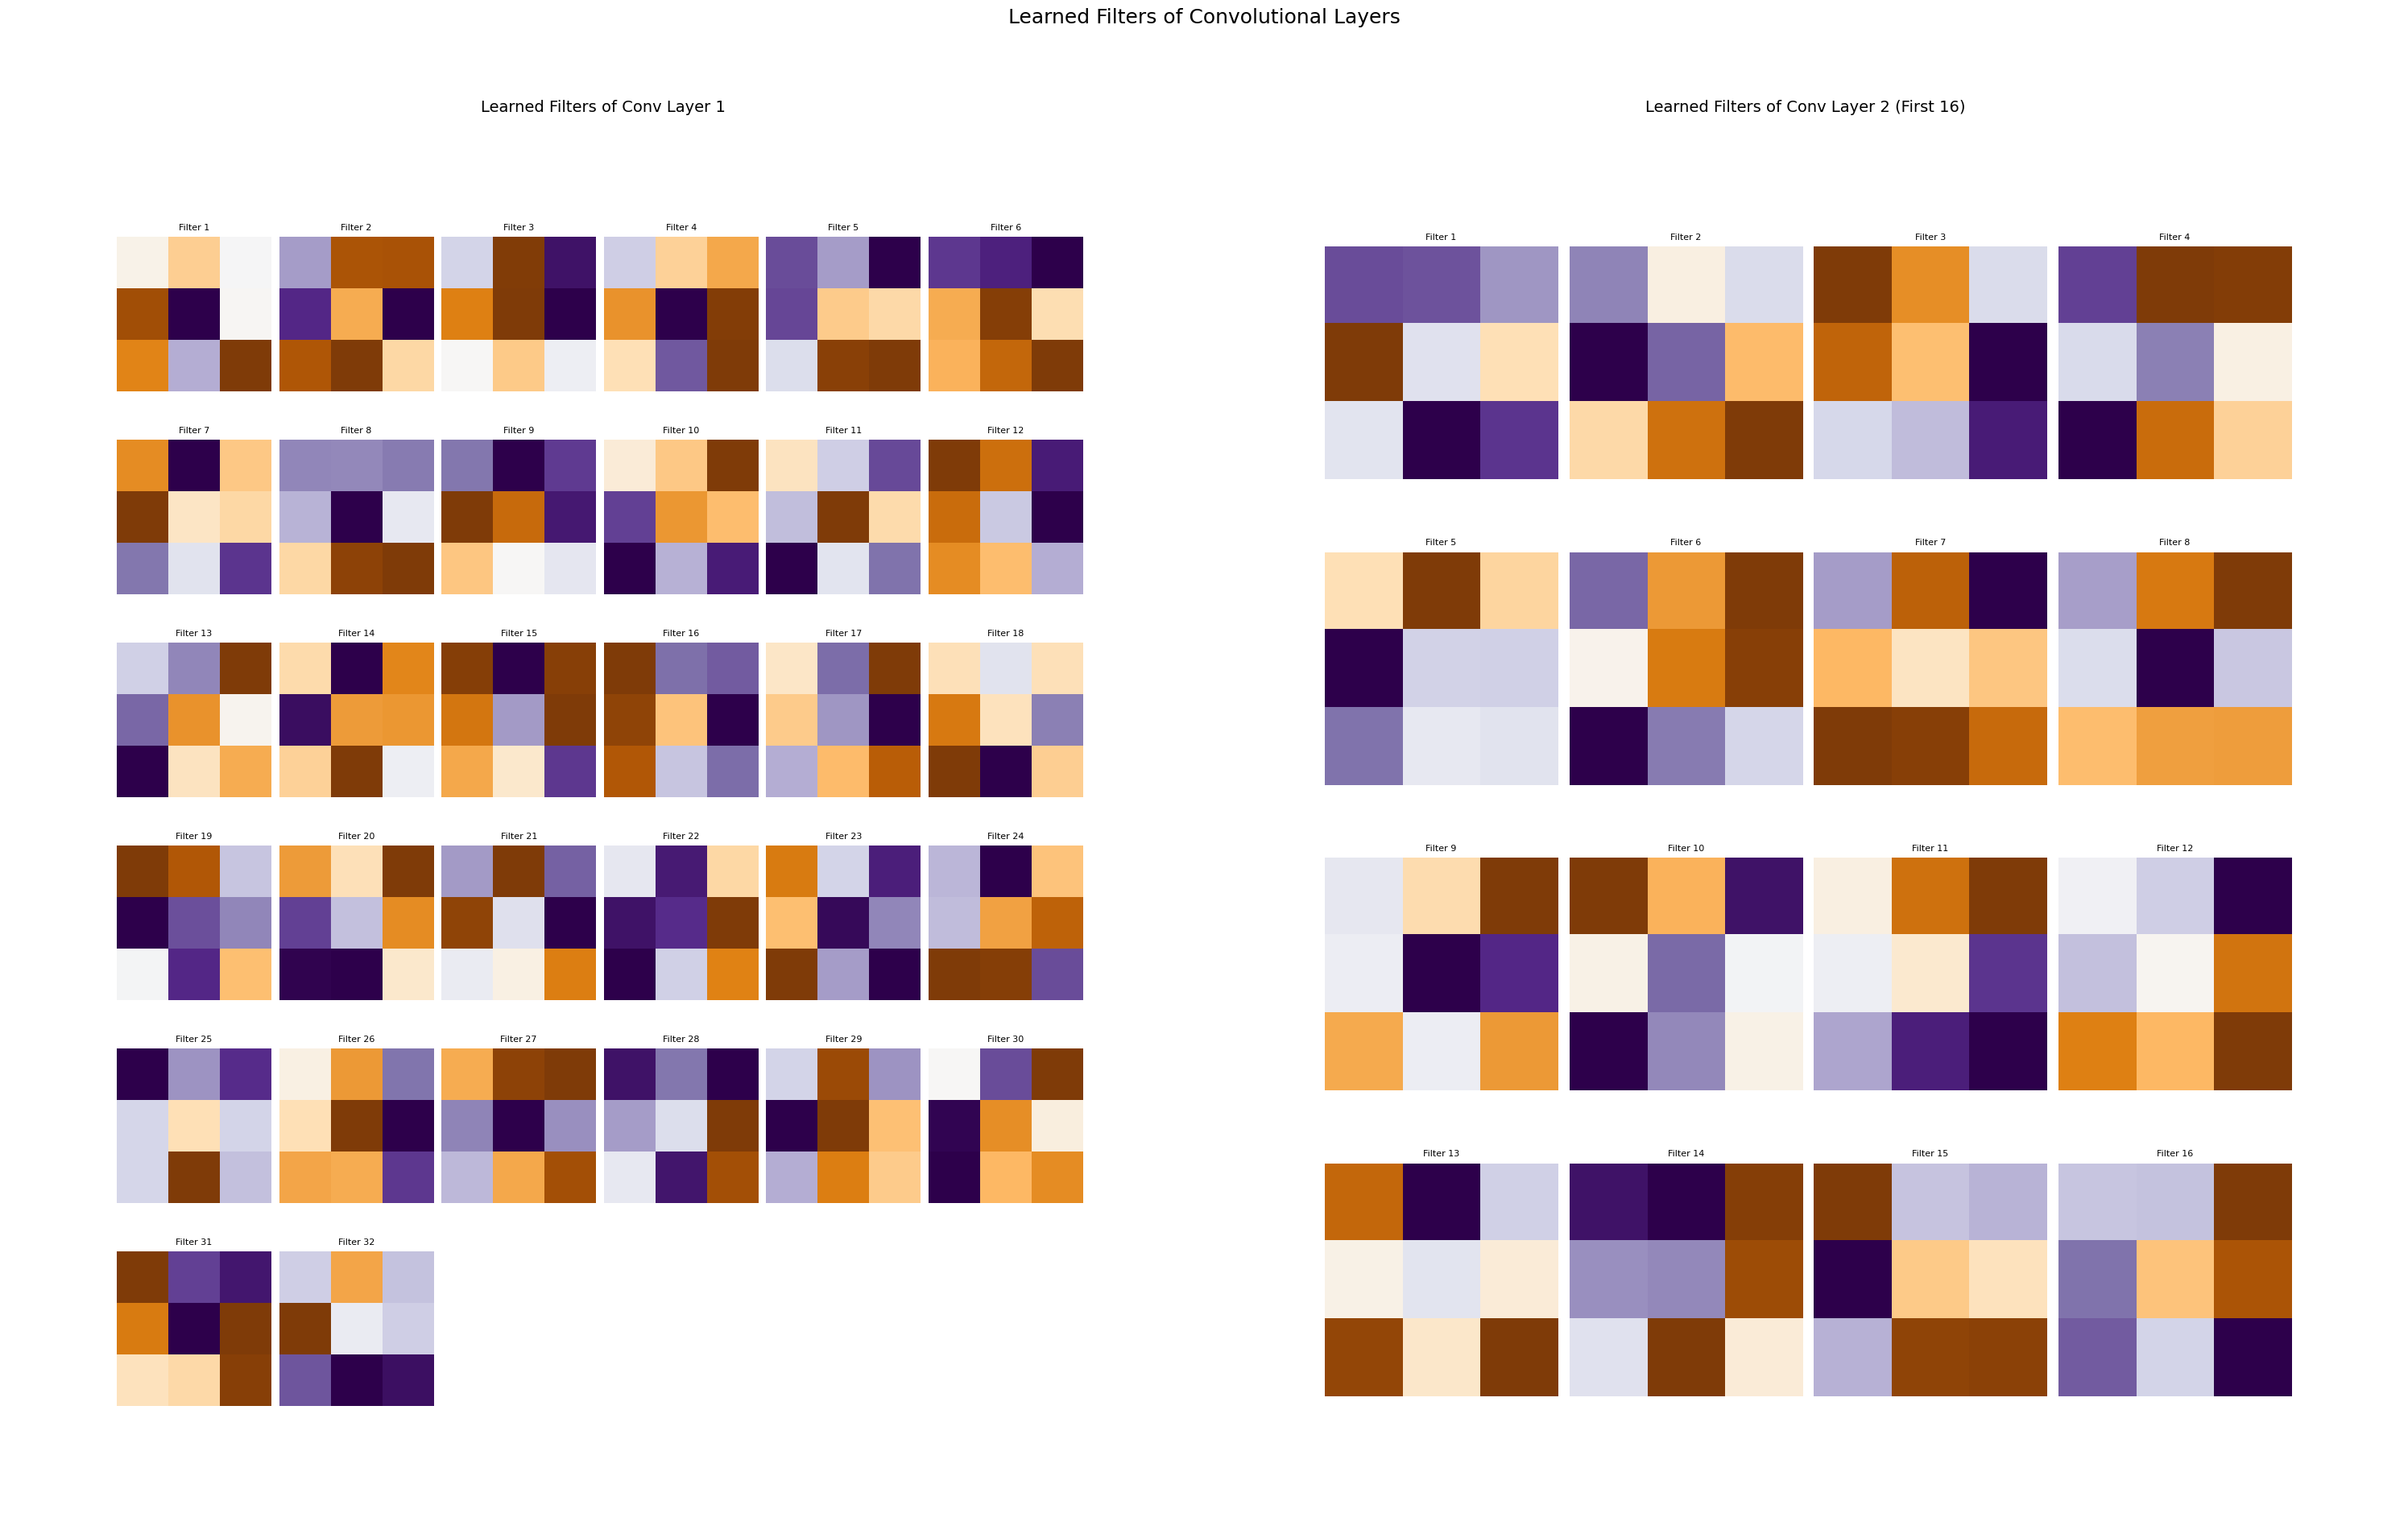

In [19]:
# --- Visualize Convolutional Layer Filters ---
print("\n--- Visualizing Convolutional Layer Filters ---")

# Access the weights of the first convolutional layer (conv1)
# Keras stores weights as a list: [kernel_weights, bias_weights]
# need the kernel_weights (the actual filters)
filters_conv1 = model.layers[0].get_weights()[0]
num_filters_conv1 = filters_conv1.shape[-1] # Number of output channels/filters

# Access the weights of the second convolutional layer (conv2)
filters_conv2 = model.layers[2].get_weights()[0] # Assuming Conv2D is at index 2
num_filters_conv2 = filters_conv2.shape[-1]

# Set a fixed figure size for both plots to be the same
fixed_figsize = (30, 20)

# Create the main figure and subplots for the filter visualization
fig, axes = plt.subplots(1, 2, figsize=fixed_figsize)

# Subplot 1: Convolutional Layer 1 Filters
ax1 = axes[0]
ax1.set_title('Learned Filters of Conv Layer 1', fontsize=14, pad=20)
ax1.axis('off')

grid_cols_conv1 = int(np.ceil(np.sqrt(num_filters_conv1)))
grid_rows_conv1 = int(np.ceil(num_filters_conv1 / grid_cols_conv1))

gs1 = plt.GridSpec(grid_rows_conv1, grid_cols_conv1, figure=fig)
gs1.update(left=0.05, right=0.45, wspace=0.05, hspace=0.05, top=0.85, bottom=0.1)

for i in range(num_filters_conv1):
    ax_filter1 = fig.add_subplot(gs1[i // grid_cols_conv1, i % grid_cols_conv1])
    # For grayscale input, filter_img is (kernel_height, kernel_width, 1, num_filters)
    # take the first (and only) input channel and squeeze
    filter_img = filters_conv1[:, :, 0, i]

    min_val, max_val = filter_img.min(), filter_img.max()
    if max_val - min_val > 1e-6:
        filter_img = (filter_img - min_val) / (max_val - min_val)
    else:
        filter_img = np.zeros_like(filter_img)

    ax_filter1.imshow(filter_img, cmap='PuOr')
    ax_filter1.set_title(f'Filter {i+1}', fontsize=8)
    ax_filter1.axis('off')

# Subplot 2: Convolutional Layer 2 Filters (First 16 for brevity)
ax2 = axes[1]
ax2.set_title('Learned Filters of Conv Layer 2 (First 16)', fontsize=14, pad=20)
ax2.axis('off')

plot_filters_count_conv2 = min(16, num_filters_conv2)
grid_cols_conv2 = int(np.ceil(np.sqrt(plot_filters_count_conv2)))
grid_rows_conv2 = int(np.ceil(plot_filters_count_conv2 / grid_cols_conv2))

gs2 = plt.GridSpec(grid_rows_conv2, grid_cols_conv2, figure=fig)
gs2.update(left=0.55, right=0.95, wspace=0.05, hspace=0.05, top=0.85, bottom=0.1)

for i in range(plot_filters_count_conv2):
    ax_filter2 = fig.add_subplot(gs2[i // grid_cols_conv2, i % grid_cols_conv2])
    # For Conv2, filters are (kernel_height, kernel_width, in_channels, out_channels)
    # take the mean across input channels to visualize
    filter_img_conv2 = filters_conv2[:, :, :, i].mean(axis=-1) # Mean across input channels

    min_val, max_val = filter_img_conv2.min(), filter_img_conv2.max()
    if max_val - min_val > 1e-6:
        filter_img_conv2 = (filter_img_conv2 - min_val) / (max_val - min_val)
    else:
        filter_img_conv2 = np.zeros_like(filter_img_conv2)

    ax_filter2.imshow(filter_img_conv2, cmap='PuOr')
    ax_filter2.set_title(f'Filter {i+1}', fontsize=8)
    ax_filter2.axis('off')

fig.suptitle('Learned Filters of Convolutional Layers', fontsize=18, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Visualizing Decision Boundary of the model


--- Visualizing CNN Decision Boundary using PCA ---
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/tmp/ipykernel_13/2511990402.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


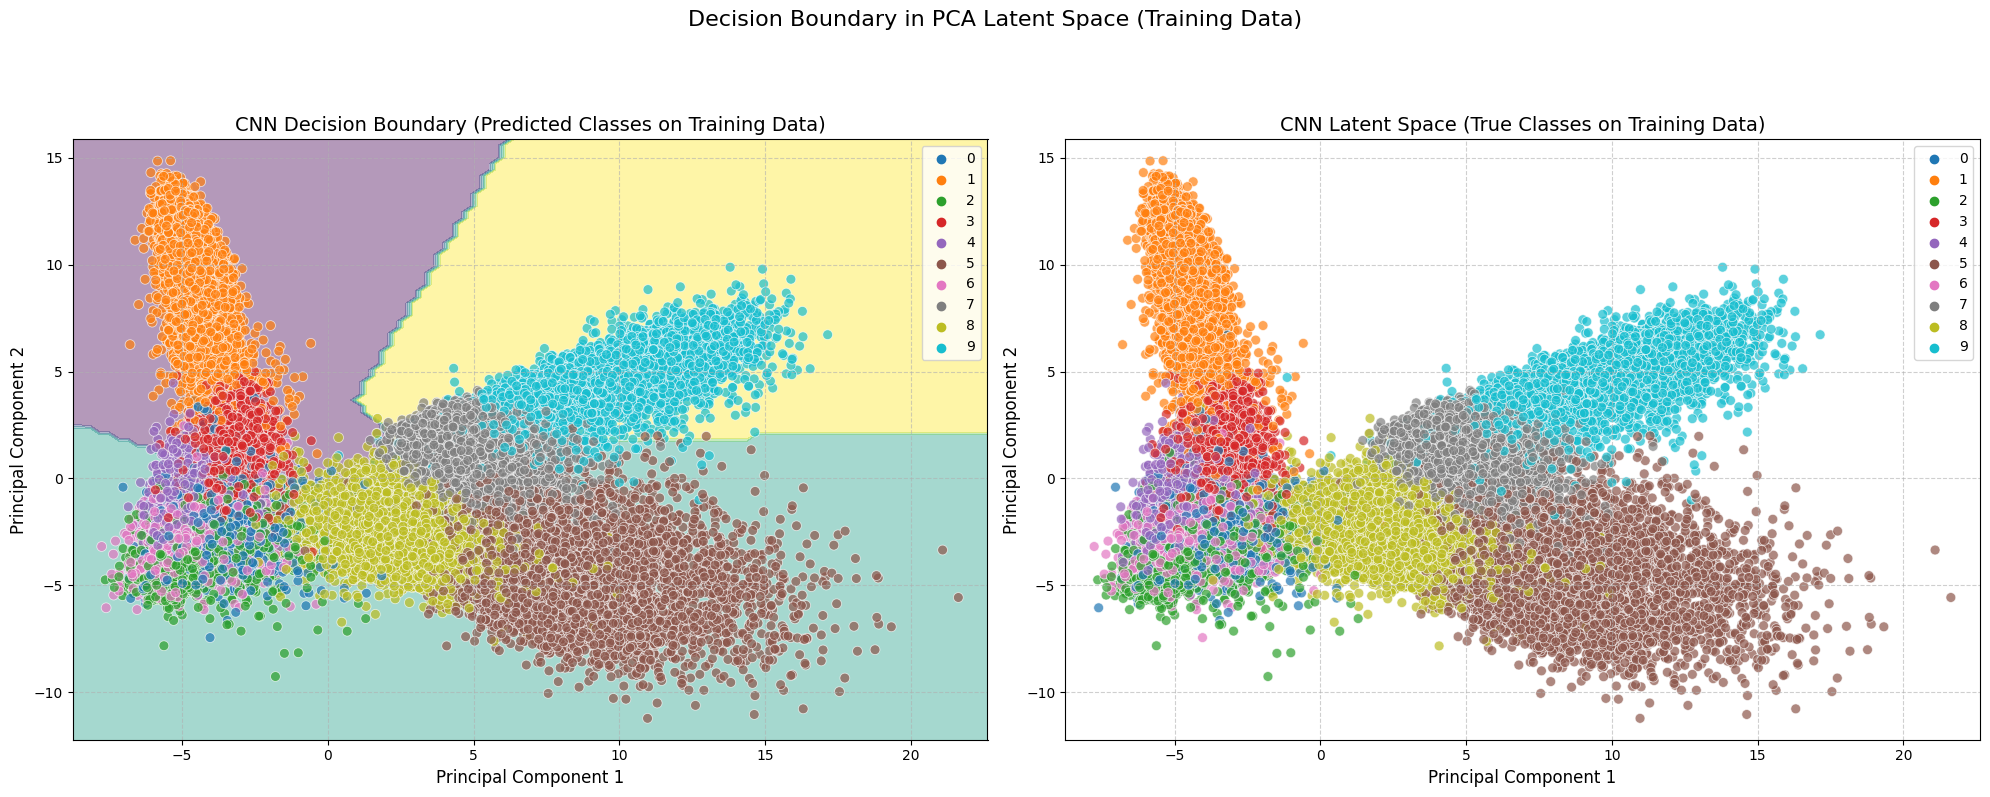

In [20]:
# --- Visualizing Decision Boundary in PCA-Reduced Latent Space ---
print("\n--- Visualizing CNN Decision Boundary using PCA ---")

# Function to create a sub-model up to the specified layer
def get_intermediate_model(model, layer_name):
    """Create a Sequential model with layers up to the specified layer name."""
    layer_index = [layer.name for layer in model.layers].index(layer_name)
    intermediate_model = Sequential(model.layers[:layer_index + 1])
    return intermediate_model

# Extract features from the 'fc_intermediate_custom' layer using the trained model
intermediate_model = get_intermediate_model(model, 'fc_intermediate_custom')
intermediate_features = intermediate_model.predict(x_train_cnn, batch_size=64)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(intermediate_features)

# Get model predictions for training data labels
predicted_labels = np.argmax(model.predict(x_train_cnn, batch_size=64), axis=1)

# Create meshgrid for decision boundary
x_min, x_max = pca_features[:, 0].min() - 1, pca_features[:, 0].max() + 1
y_min, y_max = pca_features[:, 1].min() - 1, pca_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]

# Reconstruct features from PCA space to original feature space
reconstructed_features = pca.inverse_transform(meshgrid_points)

# Create sub-model from 'fc_intermediate_custom' to output
layer_index = [layer.name for layer in model.layers].index('fc_intermediate_custom')
sub_model = Sequential(model.layers[layer_index + 1:])  # Layers after 'fc_intermediate_custom'

# Predict on reconstructed features
Z_proba = sub_model.predict(reconstructed_features, batch_size=64)
Z = np.argmax(Z_proba, axis=1).reshape(xx.shape)

# Plotting with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
cmap = plt.cm.get_cmap('viridis', num_classes)

# Left subplot: Decision Boundary with Predicted Classes
contourf_plot = ax1.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=predicted_labels,
    palette=sns.color_palette("tab10", n_colors=num_classes),
    legend='full',
    alpha=0.7,
    s=50,
    ax=ax1
)
ax1.set_title('CNN Decision Boundary (Predicted Classes on Training Data)', fontsize=14)
ax1.set_xlabel('Principal Component 1', fontsize=12)
ax1.set_ylabel('Principal Component 2', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlim(xx.min(), xx.max())
ax1.set_ylim(yy.min(), yy.max())

# Right subplot: Latent Space with True Classes
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=y_train_keras,
    palette=sns.color_palette("tab10", n_colors=num_classes),
    legend='full',
    alpha=0.7,
    s=50,
    ax=ax2
)
ax2.set_title('CNN Latent Space (True Classes on Training Data)', fontsize=14)
ax2.set_xlabel('Principal Component 1', fontsize=12)
ax2.set_ylabel('Principal Component 2', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(yy.min(), yy.max())

# Overall title
fig.suptitle('Decision Boundary in PCA Latent Space (Training Data)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Model Evaluation

In [21]:
# --- Final Evaluation on Test Set and Performance Metrics ---
print("\n--- Final Evaluation on Test Set and Performance Metrics ---")
# Use model.evaluate for final loss and accuracy
loss, accuracy = model.evaluate(x_test_cnn, y_test_keras, verbose=0)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


--- Final Evaluation on Test Set and Performance Metrics ---
Test Loss: 0.2246, Test Accuracy: 0.9167


## Classification metrics and classification reports evaluation

In [22]:
# Get predictions for metrics calculation
y_pred_proba_test_keras = model.predict(x_test_cnn) # Probabilities for each class
y_pred_test_keras = np.argmax(y_pred_proba_test_keras, axis=1) # Predicted class labels

# Calculate metrics
cm = confusion_matrix(y_test_keras, y_pred_test_keras)
accuracy_final = accuracy_score(y_test_keras, y_pred_test_keras)
precision = precision_score(y_test_keras, y_pred_test_keras, average='macro', zero_division=1)
recall = recall_score(y_test_keras, y_pred_test_keras, average='macro', zero_division=1)
f1 = f1_score(y_test_keras, y_pred_test_keras, average='macro', zero_division=1)

# Calculate ROC-AUC for multi-class classification (One-vs-Rest)
roc_auc_val = roc_auc_score(y_test_keras, y_pred_proba_test_keras, multi_class='ovr')

# Print the results
print(f"Accuracy: {accuracy_final:.3f}")
print(f"Precision (macro): {precision:.3f}")
print(f"Recall (macro): {recall:.3f}")
print(f"F1-score (macro): {f1:.3f}")
print(f"AUC-ROC (OvR): {roc_auc_val:.3f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_keras, y_pred_test_keras, zero_division=1))
print("="*40 + "\n")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.917
Precision (macro): 0.918
Recall (macro): 0.917
F1-score (macro): 0.917
AUC-ROC (OvR): 0.995

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1000
           1       0.99      0.99      0.99      1000
           2       0.88      0.84      0.86      1000
           3       0.93      0.92      0.93      1000
           4       0.91      0.86      0.88      1000
           5       0.98      0.99      0.98      1000
           6       0.76      0.74      0.75      1000
           7       0.97      0.95      0.96      1000
           8       0.99      0.99      0.99      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000




## Confusion metrics

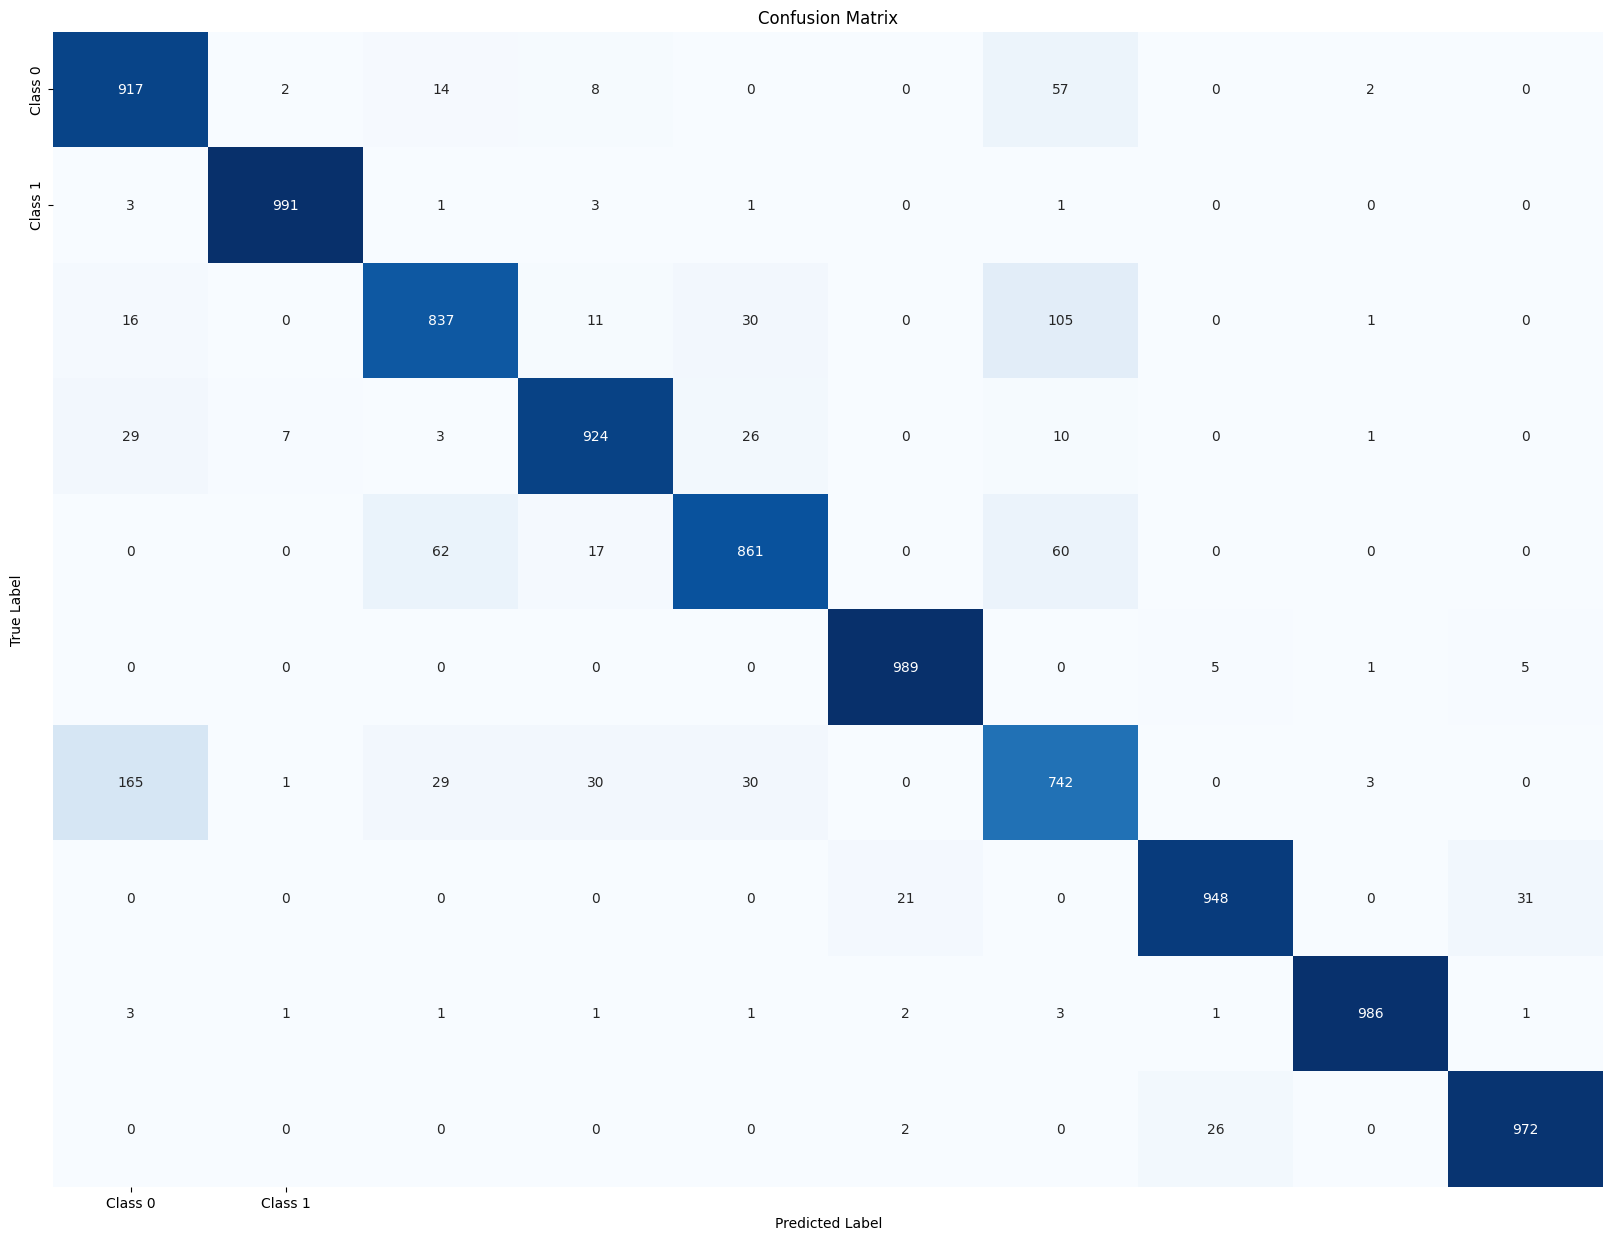

In [23]:
# --- Plotting Confusion Matrix ---
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Precision-Recall Curve


--- Plotting Precision-Recall Curve ---


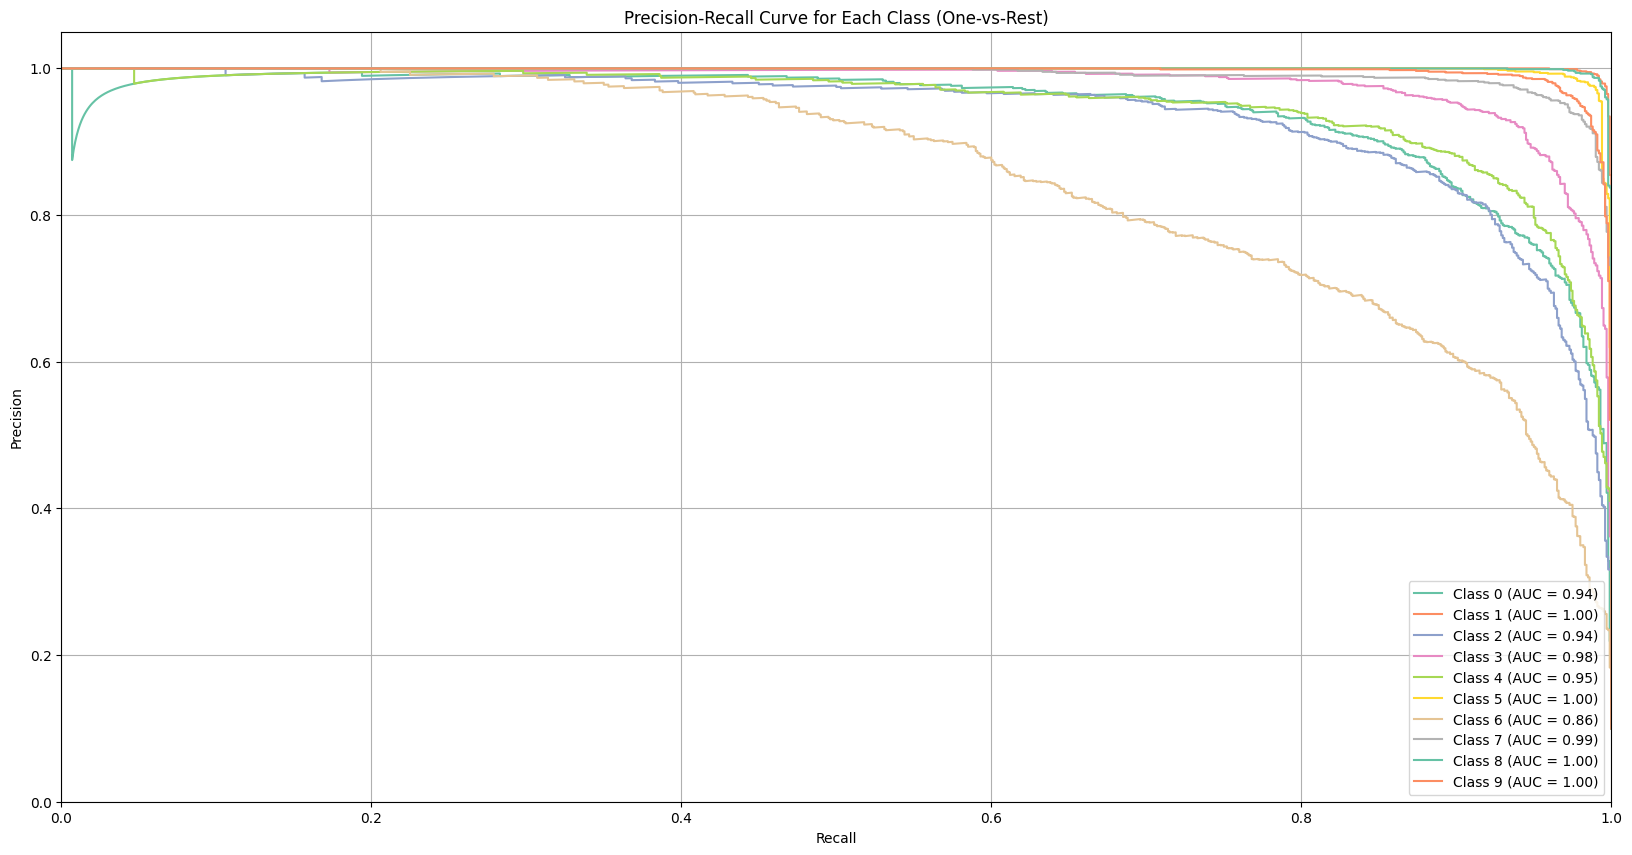

In [24]:
# --- Plotting Precision-Recall Curve ---
print("\n--- Plotting Precision-Recall Curve ---")

# Define class labels (for multi-class, these are 0-9 for Fashion MNIST)
class_labels_pr = [str(i) for i in range(num_classes)]

plt.figure(figsize=(20, 10))
sns.set_palette("Set2")

# y_pred_proba_test_keras is already calculated 
# y_test_keras is also available 

for i, label_str in enumerate(class_labels_pr):
    class_val = int(label_str)
    y_test_bin = np.where(y_test_keras == class_val, 1, 0)
    y_pred_score = y_pred_proba_test_keras[:, class_val]

    precision, recall, _ = precision_recall_curve(y_test_bin, y_pred_score)
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f'Class {label_str} (AUC = {pr_auc:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Class (One-vs-Rest)")
plt.legend(loc="lower right")
plt.ylim([0, 1.05])
plt.xlim([0, 1])
plt.grid(True)
plt.show()

## Visualizing CNN Decision Boundary on test dataset


--- Visualizing CNN Decision Boundary using PCA on Test Data ---
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/tmp/ipykernel_13/4039088178.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', num_classes)


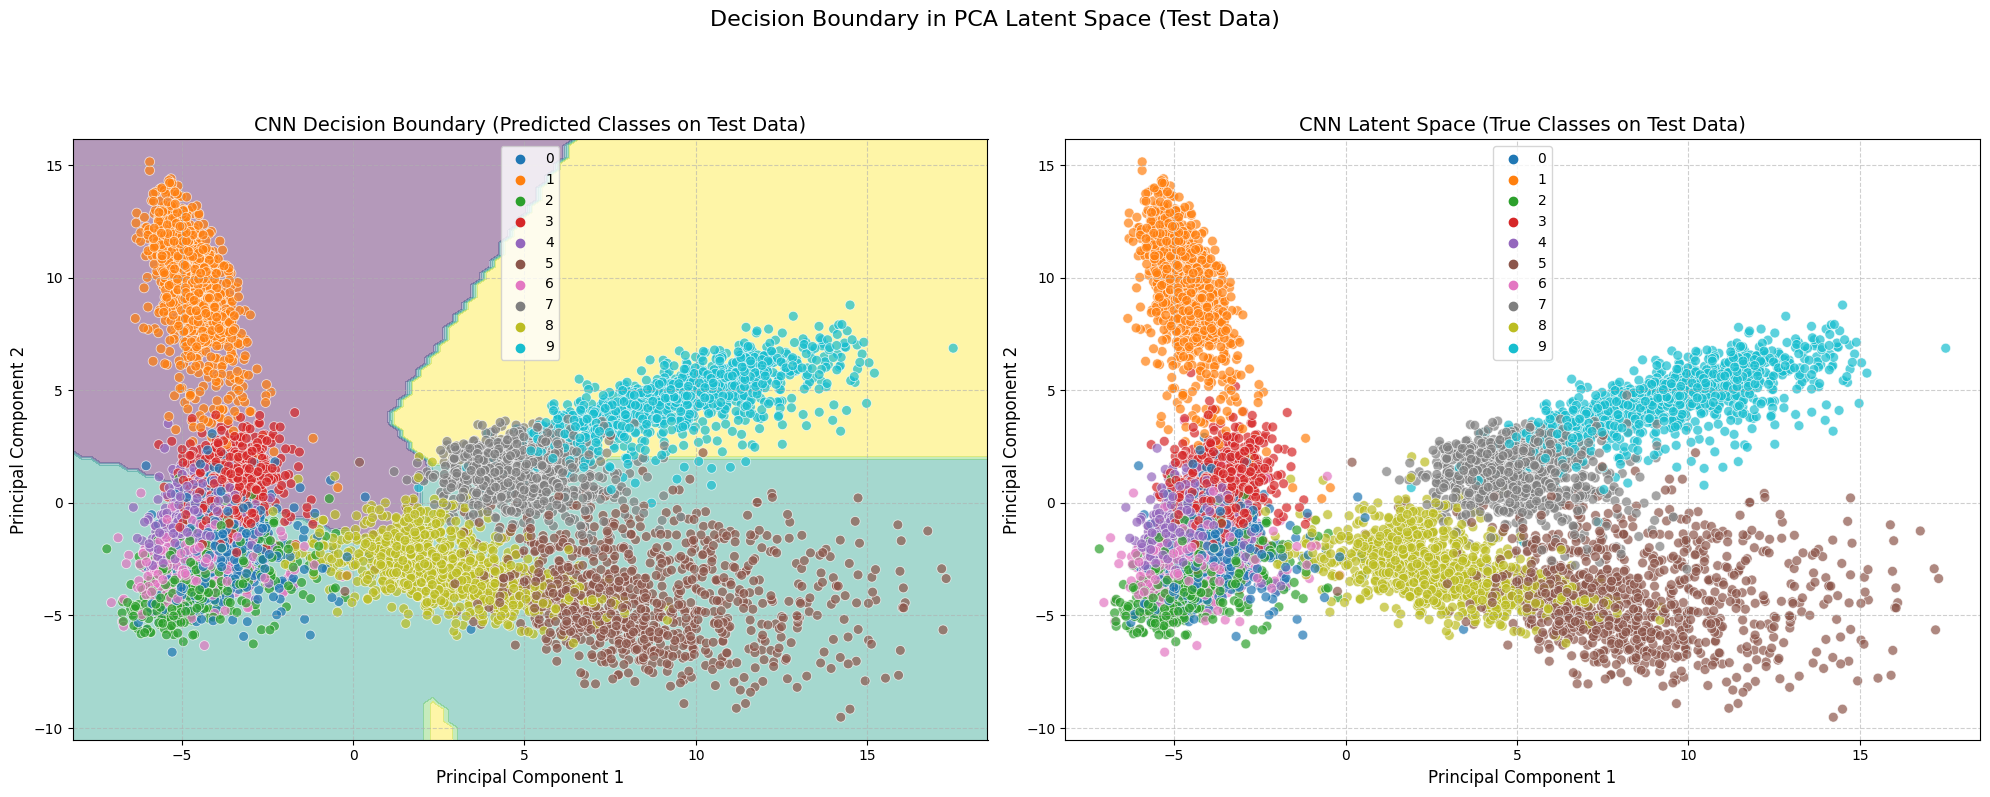

In [25]:
# --- Visualizing CNN Decision Boundary using PCA on Test Data ---
print("\n--- Visualizing CNN Decision Boundary using PCA on Test Data ---")

# Function to create a sub-model up to the specified layer
def get_intermediate_model(model, layer_name):
    """Create a Sequential model with layers up to the specified layer name."""
    layer_index = [layer.name for layer in model.layers].index(layer_name)
    intermediate_model = Sequential(model.layers[:layer_index + 1])
    return intermediate_model

# Extract features from the 'fc_intermediate_custom' layer using the trained model
intermediate_model = get_intermediate_model(model, 'fc_intermediate_custom')
intermediate_features = intermediate_model.predict(x_test_cnn, batch_size=64)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_features = pca.fit_transform(intermediate_features)

# Get model predictions for test data labels
predicted_labels = np.argmax(model.predict(x_test_cnn, batch_size=64), axis=1)

# Create meshgrid for decision boundary
x_min, x_max = pca_features[:, 0].min() - 1, pca_features[:, 0].max() + 1
y_min, y_max = pca_features[:, 1].min() - 1, pca_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
meshgrid_points = np.c_[xx.ravel(), yy.ravel()]

# Reconstruct features from PCA space to original feature space
reconstructed_features = pca.inverse_transform(meshgrid_points)

# Create sub-model from 'fc_intermediate_custom' to output
layer_index = [layer.name for layer in model.layers].index('fc_intermediate_custom')
sub_model = Sequential(model.layers[layer_index + 1:])  # Layers after 'fc_intermediate_custom'

# Predict on reconstructed features
Z_proba = sub_model.predict(reconstructed_features, batch_size=64)
Z = np.argmax(Z_proba, axis=1).reshape(xx.shape)

# Plotting with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
cmap = plt.cm.get_cmap('viridis', num_classes)

# Left subplot: Decision Boundary with Predicted Classes
contourf_plot = ax1.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=predicted_labels,
    palette=sns.color_palette("tab10", n_colors=num_classes),
    legend='full',
    alpha=0.7,
    s=50,
    ax=ax1
)
ax1.set_title('CNN Decision Boundary (Predicted Classes on Test Data)', fontsize=14)
ax1.set_xlabel('Principal Component 1', fontsize=12)
ax1.set_ylabel('Principal Component 2', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlim(xx.min(), xx.max())
ax1.set_ylim(yy.min(), yy.max())

# Right subplot: Latent Space with True Classes
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=y_test_keras,
    palette=sns.color_palette("tab10", n_colors=num_classes),
    legend='full',
    alpha=0.7,
    s=50,
    ax=ax2
)
ax2.set_title('CNN Latent Space (True Classes on Test Data)', fontsize=14)
ax2.set_xlabel('Principal Component 1', fontsize=12)
ax2.set_ylabel('Principal Component 2', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xlim(xx.min(), xx.max())
ax2.set_ylim(yy.min(), yy.max())

# Overall title
fig.suptitle('Decision Boundary in PCA Latent Space (Test Data)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()